**Báo cáo cuối kỳ môn học: PYTHON CHO KHOA HỌC DỮ LIỆU**

**Lớp 23TTH, Khoa Toán - Tin học, Trường Đại học Khoa học Tự nhiên, ĐHQG-HCM**

**Đề tài thực hiện:**
$$
\text{\textbf{USING DEEP LEARNING TO CLASSIFY ANIMAL AND HUMAN IMAGES}}
$$

**Giảng viên hướng dẫn: ThS. Hà Văn Thảo**

**Danh sách thành viên nhóm:**

1. 23110114 - Nguyễn Thị Hồng Thắm \
2. 23110123 - Lê Huỳnh Yến Vy \
3. 23110132 - Trần Nhật Anh

## GIỚI THIỆU

Object detection là một trong những chủ đề "nóng" trong deep learing bởi tính ứng dụng cao trong thực tiễn và nguồn dữ liệu dồi dào, dễ chuẩn bị. Một trong những thuật toán object detection nổi tiếng nhất là **YOLO**.

YOLO là mô hình mạng neuron tích chập (CNN) được sử dụng phổ biển để nhận dạng các đối tượng trong ảnh hoặc video. Điểm đặc biệt của mô hình này là có khả năng phát hiện tất cả các đối tượng trong một hình ảnh chỉ qua một lần lan truyền của CNN.

Các phương pháp truyền thống tách biệt bước đề xuất vùng và bước phân loại, YOLO xử lý đầu vào, vừa phân loại được các đối tượng, vừa dự đoán được vị trí của chúng trong một lần duy nhất.

YOLO có nghĩa là "You only look once", nghĩa là chỉ cần "nhìn" một lần là thuật toán đã có thể phát hiện được vật thể, cho thấy độ nhanh của thuật toán gần như là real-time.

Ứng dụng của YOLO cũng như nhiều thuật toán object detection khác, rất đa dạng: quản lý giao thông, đếm số sản phẩm trên băng chuyền nhà máy, đếm số vật nuôi trong chăn nuôi, phát hiện vật thể nguy hiểm (súng, dao,...), chấm công tự động,...

## TẠO MÔI TRƯỜNG ẢO VÀ KERNEL CHẠY NOTEBOOK (LINUX)

Dự án Python cần **môi trường ảo (virtual environment)** để tự cách ly, tránh xung đột phiên bản thư viện giữa các dự án. `venv` là môi trường ảo mà chúng ta sẽ sử dụng trong dự án này. Sau khi cài đặt `venv`, chúng ta di chuyển đường dẫn đến folder chứa dự án trong terminal và sử dụng lệnh sau để cài đặt môi trường ảo cho dự án:

`python -m venv .venv`

Trong đó, `.venv` là tên của folder chứa môi trường ảo của dự án, đồng thời nó cũng sẽ "đóng băng" phiên bản Python, pip và các thư viện sẽ được dùng trong dự án.

Kích hoạt môi trường ảo:

`source .venv/bin/activate`

Lúc này, phiên bản Python và `pip` được dùng là của môi trường ảo, các thư viện cài bằng `pip install` cũng chỉ ảnh hưởng trong `.venv`. Cách nhận biết đang ở môi trường ảo là promt terminal thường đổi thành `(.venv) user_name@machine:~` (nếu đang sử dụng Linux). Khi đã kích hoạt môi trường ảo, đảm bảo phiên bản Python và `pip` đã "đóng băng" trong đó, sử dụng lệnh:

`which python && which pip`

Nếu output có dạng `.../<project_name>/.venv/...` thì môi trường ảo đã được kích hoạt thành công.

Tiếp theo, tạo một kernel để chạy Jupyter Notebook. Cài đặt `ipykernel` để tạo kernel:

`python -m pip install ipykernel`

Sau khi cài đặt thành công, tiến hành tạo kernel để chạy file `.ipynb`:

`python -m ipykernel install --prefix .venv --name yolovenv --display-name "this_project"`

`--prefix .venv`: kernel mặc định không tự lưu vào `.venv`, thuộc tính này sẽ lưu kernel đã tạo vào `.venv`  
`--name yolovenv`: tên folder chứa kernel, ở đây tên folder là `yolovenv`. Kernel sẽ được lưu tại `.venv/share/jupyter/kernels/yolovenv/`  
`--display-name "this_project`: kernel sẽ hiển thị dưới tên `this_project` trong VS Code.

Khi đã tạo kernel, click vào biểu tượng kernel ở góc trên bên phải, chọn
$$
\text{Select Another Kernel} \rightarrow \text{Jupyter Kernel...} \rightarrow \text{this\_project}
$$

# CÁC THƯ VIỆN CẦN DÙNG

In [325]:
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd
from pathlib import Path
import seaborn as sns
from ultralytics import YOLO

# CHUẨN BỊ VÀ TỔNG QUAN VỀ DỮ LIỆU

## CHUẨN BỊ DỮ LIỆU

Dữ liệu được tải về tại các nguồn sau: \
- https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset \
- https://www.kaggle.com/datasets/biancaferreira/african-wildlife \
- https://www.kaggle.com/datasets/wutheringwang/dog-face-detectionyolo-format \
- https://www.kaggle.com/datasets/samuelayman/cat-dataset \
- https://universe.roboflow.com/labo-yolo/age-and-gender-xlnfj/dataset/3

Dữ liệu sau khi được tải về sẽ được xử lý (gán lại class ID; phân loại thành các folder train, valid, test;...), sau đó được gộp thành một folder tập dữ liệu (dataset) duy nhất. Dataset nếu muốn được YOLO "hiểu" thì phải có file `.yaml` chứa các thông tin về dataset như vị trí của file train, valid, test; số class; tên của các class ứng với mỗi class_id;...

Dataset của dự án này nằm tại `dataset/complete_dataset`, bao gồm: \
- folder `images` chứa các file ảnh, được chia thành ba folder train, valid, test. \
- folder `labels` chứa các file **nhãn dữ liệu (label)** có đuôi `.txt`, cũng được chia thành ba folder train, valid, test và các file label có tên ứng với các file ảnh. \
- file `.yaml` để cung cấp thông tin về dataset cho YOLO.

In [326]:
DATASET_PATH = "dataset/complete_dataset/data.yaml"

## LÀM SẠCH VÀ CHUẨN HOÁ DỮ LIỆU

Trước khi đưa dataset vào huấn luyện mô hình, cần làm sạch và chuẩn hoá dataset để tránh các lỗi crash, lỗi đọc ảnh,... trong quá trình huấn luyện.

In [327]:
def check_flag_file(BASE_DIR):
    flag_file = BASE_DIR / "flag_file.txt"

    if not flag_file.exists():
        return False
    
    with open(flag_file, 'r') as file:
        return file.read().strip() == "This dataset has been re-saved already."

In [328]:
def create_flag_file(BASE_DIR):
    if check_flag_file(BASE_DIR):
        return
    
    flag_file = BASE_DIR / "flag_file.txt"
    content = "This dataset has been re-saved already."

    with open(flag_file, 'w') as file:
        file.write(content)

In [329]:
def resave(IMAGES_DIR, LABELS_DIR):
    fixed = 0
    removed = 0

    for root, _, files in os.walk(IMAGES_DIR):
        for file in files:
            if not file.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                continue

            # Ghép IMAGES_DIR với tên file ảnh thành path file ảnh
            image_path = os.path.join(root, file)

            try:
                # Mở ảnh để verify nhanh, nếu ảnh có vấn đề -> exception
                with Image.open(image_path) as image:
                    image.verify()

                # Mở lại để re-save
                with Image.open(image_path) as image:
                    image = image.convert("RGB")
                    image.save(image_path, "JPEG", quality=95, subsampling=0)

                fixed += 1

            except Exception:
                # Nếu ảnh hỏng -> xoá file ảnh cùng với file label tương ứng
                os.remove(image_path)
                removed += 1

                relative_path = os.path.relpath(root, IMAGES_DIR)

                label_path = os.path.join(
                    LABELS_DIR,
                    relative_path,
                    os.path.splitext(file)[0] + ".txt"
                )

                if os.path.exists(label_path):
                    os.remove(label_path)

    return fixed, removed

In [330]:
def resave_images(BASE_DIR, IMAGES_DIR, LABELS_DIR):
    if check_flag_file(BASE_DIR):
        return 0, 0
    else:
        fixed, removed = resave(IMAGES_DIR, LABELS_DIR)
        create_flag_file(BASE_DIR)

        return fixed, removed

In [331]:
BASE_DIR = Path("dataset/complete_dataset")
IMAGES_DIR = "dataset/complete_dataset/images"
LABELS_DIR = "dataset/complete_dataset/labels"

fixed, removed = resave_images(BASE_DIR, IMAGES_DIR, LABELS_DIR)

print("Fixed  :", fixed)
print("Removed:", removed)

Fixed  : 0
Removed: 0


Sau khi hoàn tất xử lý dataset, dùng hàm `count_missing` để kiểm tra xem với mỗi file ảnh thì có file label tương ứng hay không.

In [332]:
def count_missing(BASE_DIR, image_exts, sub_folder):
    images_dir = BASE_DIR / "images" / sub_folder
    labels_dir = BASE_DIR / "labels" / sub_folder

    images_cnt = 0
    missing_cnt = 0

    for image in images_dir.iterdir():
        if image.suffix.lower() not in image_exts:
            continue

        images_cnt += 1
        """
        image.stem dùng để lấy tên của file image mà không có phần mở rộng
        Ví dụ: example123.png -> example123
        """
        label_file = labels_dir / f"{image.stem}.txt"
        if not label_file.exists():
            missing_cnt += 1

    return images_cnt, missing_cnt

Kiểm tra số ảnh bị thiếu label tương ứng.

In [333]:
BASE_DIR = Path("dataset/complete_dataset")
image_exts = {".jpg", ".jpeg", ".png", ".webp"}
sub_folders = ["train", "valid", "test"]

print(f"Checking dataset: {str(BASE_DIR)}\n")

total_images = 0
total_missing = 0
images_cnt_arr = np.array([])
missing_cnt_arr = np.array([])
missing_percent_arr = np.array([])

for sub_folder in sub_folders:
    images_cnt, missing_cnt = count_missing(BASE_DIR, image_exts, sub_folder)
    total_images += images_cnt
    total_missing += missing_cnt

    missing_percent = (missing_cnt / images_cnt) * 100 if images_cnt > 0 else 0

    images_cnt_arr = np.append(images_cnt_arr, images_cnt)
    missing_cnt_arr = np.append(missing_cnt_arr, missing_cnt)
    missing_percent_arr = np.append(missing_percent_arr, missing_percent)

images_percent = np.array([(images_cnt / total_images) * 100 \
                           for images_cnt in images_cnt_arr])

np_table = np.array([images_cnt_arr, images_percent, \
                     missing_cnt_arr, missing_percent_arr])
table = pd.DataFrame(np_table).transpose()
table.columns = ["images", "images/total (%)", "missing_labels", "missing_labels (%)"]
table.index = ["train", "valid", "test"]
table['images'] = table['images'].astype(int)
table['missing_labels'] = table['missing_labels'].astype(int)

missing_percent = (total_missing / total_images) * 100 \
    if total_images > 0 else 0

print(table)
print("")
print(f"-> Total images:       {total_images}")
print(f"-> Total missing:      {total_missing}")
print(f"-> Total missing (%):  {missing_percent}")

Checking dataset: dataset/complete_dataset

       images  images/total (%)  missing_labels  missing_labels (%)
train   20451         65.619585               0                 0.0
valid    6078         19.502021               0                 0.0
test     4637         14.878393               0                 0.0

-> Total images:       31166
-> Total missing:      0
-> Total missing (%):  0.0


Dataset có tổng cộng 31166 ảnh và mỗi ảnh đều có file label tương ứng.

## PHÂN BỐ CÁC CLASS

Dataset có 85 class được đánh số từ 0 đến 84. Do được tải về từ nhiều nguồn nên phân bố các class không đều (có class nhiều ảnh, chiếm ưu thế hơn so với một class nào đó,...).

In [334]:
CLASS_COUNT = 85

In [335]:
LABELS_DIR = BASE_DIR / "labels"

counter = Counter()

for label_file in LABELS_DIR.rglob("*.txt"):
    with open(label_file, "r") as file:
        for line in file:
            if line.strip():
                class_id = int(line.split()[0])
                counter[class_id] += 1

df = pd.DataFrame(
    sorted(counter.items()),
    columns=["class_id", "object_count"]
)

df = df.sort_values("object_count", ascending=False, ignore_index=True)
total_objects = df["object_count"].sum()
df["object_count (%)"] = (df["object_count"] * 100 / total_objects).round(5)
print(f"Total objects: {total_objects}")

Total objects: 36243


In [336]:
df

,class_id,object_count,object_count (%)
0,83,6340,17.49303
1,3,2774,7.65389
2,17,1647,4.54433
3,48,1603,4.42292
4,36,1246,3.43791
...,...,...,...
74,24,33,0.09105
75,75,26,0.07174
76,67,16,0.04415
77,1,8,0.02207


Có 85 class nhưng bảng `df` chỉ có 79 dòng, nghĩa là có 6 class không có object. Các `class_id` không có object nào là 25, 40, 50, 54, 57, 58.

In [337]:
all_classes = set(range(85))
found_classes = set(counter.keys())

missing_classes = sorted(all_classes - found_classes)
print("Missing class_ids:", missing_classes)
print("Number of missing classes:", len(missing_classes))

Missing class_ids: [25, 40, 50, 54, 57, 58]
Number of missing classes: 6


In [338]:
df_top15 = df.sort_values(by="object_count", 
                          ascending=False, 
                          ignore_index=True).head(15)

# Sắp xếp df theo thứ tự tăng dần của cột object_count rồi lấy 15 dòng đầu tiên
df_bottom15 = df.sort_values(by="object_count", 
                             ascending=True, 
                             ignore_index=True).head(15)

In [339]:
plot_size = (6, 6)

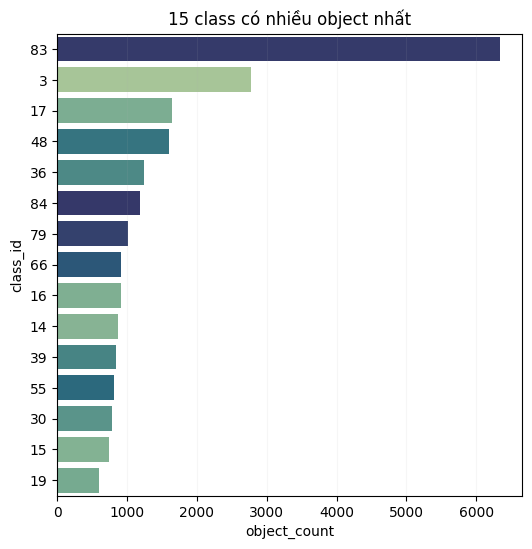

In [340]:
plt.figure(figsize=plot_size)

order = (
    df_top15
    .sort_values("object_count", ascending=False)["class_id"]
    .astype(str)
)

sns.barplot(
    data=df_top15,
    x="object_count",
    y=df_top15["class_id"].astype(str),
    order=order,
    hue="class_id",
    palette="crest",
    legend=False,
    errorbar=None
)

plt.xlabel("object_count")
plt.ylabel("class_id")
plt.title("15 class có nhiều object nhất")
plt.grid(axis='x', alpha=0.1)
plt.show()


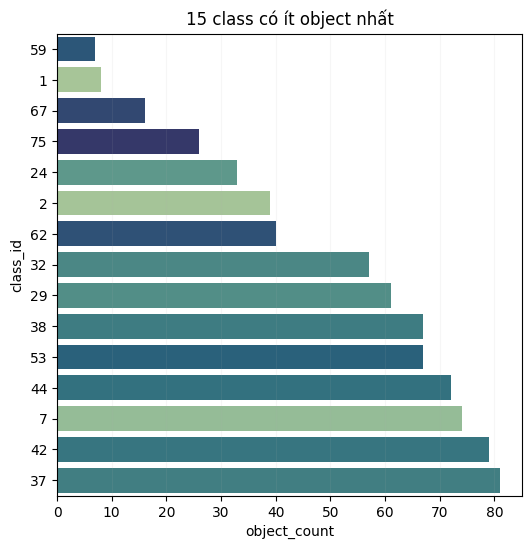

In [341]:
plt.figure(figsize=plot_size)

order = (
    df_bottom15
    .sort_values("object_count", ascending=True)["class_id"]
    .astype(str)
)

sns.barplot(
    data=df_bottom15,
    x="object_count",
    y=df_bottom15["class_id"].astype(str),
    order=order,
    hue="class_id",
    palette="crest",
    legend=False,
    errorbar=None
)

plt.xlabel("object_count")
plt.ylabel("class_id")
plt.title("15 class có ít object nhất")
plt.grid(axis='x', alpha=0.1)
plt.show()


# KHAI BÁO, HUẤN LUYỆN VÀ LƯU MÔ HÌNH

Phiên bản các thư viện dùng để huấn luyện mô hình: \
- Ultralytics 8.3.243 \
- Python-3.12.8 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX A6000, 48541MiB)

Mô hình sẽ được huấn luyện với hai hàm `train_model` và `train_model_with_optimization`. Hàm `train_model_with_optimization` có thêm các tham số tối ưu hoá, huấn luyện mô hình để cho ra các kết quả dùng để so sánh ở các phần sau.

Optimizer mặc định của YOLO11s/YOLO11m là `SGD`, mô hình sẽ được huấn luyện để so sánh với optimizer `AdamW`.

In [342]:
def train_model(model, epochs, imgsz, dataset_path, project_path, project_name):
    model.train(
        exist_ok=True,
        data=dataset_path,
        project=project_path,
        name=project_name,

        epochs=epochs,
        imgsz=imgsz,
        batch=32,
        workers=12,
        seed=42,
        device=0,  # sử dụng GPU

        cos_lr=True,

        mosaic=0.1,
        mixup=0.0,
        copy_paste=0.0,

        optimizer="SGD",
        lr0=0.01,
        momentum=0.937,
        weight_decay=5e-4,
    )


def train_model_with_optimization(model, epochs, imgsz, dataset_path, 
                                  project_path, project_name):
    model.train(
        exist_ok=True,
        data=dataset_path,
        project=project_path,
        name=project_name,

        epochs=epochs,
        imgsz=imgsz,
        batch=32,
        workers=12,
        seed=42,
        device=0,  # sử dụng GPU

        cos_lr=True,

        mosaic=0.1,
        mixup=0.0,
        copy_paste=0.0,

        optimizer="AdamW",
        lr0=0.001,
        weight_decay=1e-2,
    )

Sử dụng model YOLO11s và chuẩn bị các tham số để chuẩn bị train.

In [343]:
BASE_MODELS = ["yolo11s", "yolo11m"]

epochs_list = [30, 80]
imgsz_list = [448, 640]
with_optimization_list = [0, 1]  # 0 = không optimization, 1 = có optimization

# Huấn luyện mô hình với các thông số khác nhau
parameters = list(product(epochs_list, imgsz_list, with_optimization_list))

Huấn luyện mô hình với các tham số khác nhau dựa trên YOLO11s và YOLO11m.

In [344]:
for base_model in BASE_MODELS:
    for parameter in parameters:
        epochs, imgsz, with_optimization = parameter

        """
        Lưu model tại "runs/{...}/epochs{...}_imgsz{...}_optimization{...}"
        sau khi train
        """
        best_path = (
            Path(f"runs/{base_model}")
            / f"epochs{epochs}_imgsz{imgsz}_optimization{with_optimization}"
            / "weights"
            / "best.pt"
        )
        model_path = f"runs/{base_model}"
        model_name = f"epochs{epochs}_imgsz{imgsz}_optimization{with_optimization}"

        # Huấn luyện mô hình với dataset
        if best_path.exists():
            print(str(best_path))
            print(f"Model has been trained already. It is being loaded again...")
            model = YOLO(str(best_path))
        else:
            print(str(best_path))
            print("Model hasn't been trained. Start training...")

            # Huấn luyện mô hình dựa trên mô hình gốc
            model = YOLO(base_model)
            if with_optimization:
                train_model_with_optimization(
                    model=model,
                    epochs=epochs,
                    imgsz=imgsz,
                    dataset_path=DATASET_PATH,
                    project_path=model_path,
                    project_name=model_name
                )
            else:
                train_model(
                    model=model,
                    epochs=epochs,
                    imgsz=imgsz,
                    dataset_path=DATASET_PATH,
                    project_path=model_path,
                    project_name=model_name
                )

            # Load lại best.pt sau khi train, nếu không tìm thấy thì in ra lỗi
            assert best_path.exists(), "Training finished but file best.pt not found"
            model = YOLO(str(best_path))

            print("Training finished")

runs/yolo11s/epochs30_imgsz448_optimization0/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs30_imgsz448_optimization1/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs30_imgsz640_optimization0/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs30_imgsz640_optimization1/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz448_optimization0/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz448_optimization1/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz640_optimization0/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz640_optimization1/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11m/epochs30_imgsz448_o

In [345]:
cols = ["metrics/mAP50(B)"]
max_mAP50 = np.array([])

for base_model in BASE_MODELS:
    for parameter in parameters:
        epochs, imgsz, with_optimization = parameter
        results_path = (
            Path(f"runs/{base_model}")
            / f"epochs{epochs}_imgsz{imgsz}_optimization{with_optimization}"
            / "results.csv"
        )

        data = pd.read_csv(results_path, usecols=cols).to_numpy()
        max_result = max(data)
        max_mAP50 = np.append(max_mAP50, max_result)

print(max_mAP50)
print(max(max_mAP50))
print(min(max_mAP50))

[    0.63171     0.62606     0.64837     0.65413     0.68338     0.66948     0.69382     0.67878     0.62506     0.58683     0.64579     0.58599     0.68512      0.6574     0.69949     0.66558]
0.69949
0.58599


## TEST